 # Predicting User behaviour based on e-commerce data
*__Author:__ Tino Merl*

__Table of Contents__

* [Introduction and planned action](#intro)
    * [CRISP-DM](#crisp)
* [Business Understanding](#bus_und)
* [Data Understanding](#dat_und)
    * [Describing the files](#fil_descr)
    * [Describing the columns](#col_descr)
    * [Plotting the data by groups](#plt_grps)
* [Data Preparation](#dat_pre)
* [Modeling](#model)
* [Evaluation](#eval)

## Introduction and planned action<a class="anchor" id="intro"></a>
This is an assignment for the module applied programming in the summerterm of 2020 at the *FOM Hochschule für Oekonomie & Management* at the study center in cologne. Troughout this assignment i will work with a dataset which contains user data from an e-commerce system. The dataset can be found on kaggle named *Retailrocket recommender system dataset*.[[1](#kaggle_dataset)] The dataset contains four individual files. Since two of them (item_properties_part1 and item_properties_part2) exceed the maximum filesize allowed on github i am not able to upload them to this repository. The goal of this assignment is to predict user behaviour. This can be done in two ways. The Users can be clustered in a way to predict whether a user contains to a group that buys or not. It can also be done by using markov chains to calculate the probability of a user buying or not. This whole analysis will be done via the CRISP-DM Process. 

### CRISP-DM<a class="anchor" id="crisp"></a>
CRISP-DM stands for __C__ross __I__ndustry __S__tandard __P__rocess for __D__ata __M__ining. It is a standardized process which describes the steps a machine learning analysis and model building should undertake. The steps are the following six.

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

They may be listed in a sequential manner, but there is a lot of back and forth between the steps. Especially between Business Understanding and Data Understanding, Business Understanding and Evaluation such as Data Preparation and modeling. Figure 1 illustrates the circular nature of the process.

<div style="margin:auto;">
<img style="display:block; margin-left: auto; margin-right:auto;" src="img/crisp-dm_diagramm.png"/>
<div style="width: 50%; margin:0 auto; text-align:center;"><i><b>Figure 1:</b></i> CRISP-DM diagram by statistik-dresden.de[<a href="#crisp-dm_diagramm">2</a>]</div>
</div>

Since this is an assignment the last step, the deployment, will be left out. We will therefore end the process with step number five: evaluation.

## Business Understanding<a class="anchor" id="bus_und"></a>

The first step is the business understanding. In this step the concrete goals and requirements are set before the analysis begins. The concrete tasks will also be defined here.[[2](#crisp-dm_diagramm)] For this assignment the concrete tasks will be the following.

* *Explorative analysis of the data in data understanding*
* *Cluster unusual user behaviour and filter them out*
* *Can the user behaviour be predicted with markov chains?*

Tasks may be target of changes and additions.

## Data Understanding<a class="anchor" id="dat_und"></a>

As the next step is the data understanding we should usually try to understand the data by talking with stakeholders and data owners. This is then followed by an explorative analysis of the dataset, which also creates the foundation for the following chapter the data preparation. Since this dataset has a usability score of 8.8 kaggle and has also a lot of context describing the dataset i will cite the kaggle page.[[1](#kaggle_dataset)]

### Describing the files<a class="anchor" id="fil_descr"></a>
The kaggle description seems to be a little outdated since it only speaks of three files but there are four available to download. Therefore the citation is more indirect and may differ from the original description on kaggle. As alreay mentioned the dataset consists of the following four files.

__events.csv__

A file containing the user behaviour. E.g. if a user viewed an item or added it to their cart with the corresponding item and userId and their respective timestamp.[[1](#kaggle_dataset)]

__item_properties_part1.csv and item_properties_part2.csv__

Two files containing the item properties. This refers to the property and the value of the item as their respective itemid and a timestamp. These files contain weekly snapshots of the item properties. If the property or the value of an item differs between these weekly snapshots a new row for this item will be added to the files. Since they are mostly the same files they can and will be added to one object as a union. The tricky part of this dataset is how the columns `property` and `value` refer to each other. Every value in these two columns was hashed. Except for the entries `available` and `categoryid`. When the column `property` has the entry `available` the column `value` refers to the availability of the item. Containing 1 for available and 0 for not. However if `property` contains the entry `categoryid` `value` refers to the item's category referencing the *category_tree.csv* file. All other values were stemmed and hashed. However the numeric values are marked with an n.[[1](#kaggle_dataset)] The description of the Dataset is cited as followed: 

> All words in text values were normalized (stemming procedure: https://en.wikipedia.org/wiki/Stemming) and hashed, numbers were processed as above, e.g. text "Hello world 2017!" will become "24214 44214 n2017.000"[[1](#kaggle_dataset)]

__category_tree.csv__

This files specifies a categoryId and their respective parentId.[[1](#kaggle_dataset)]

### Describing the columns<a class="anchor" id="col_descr"></a>


The following descriptions are taken from the kaggle dataset.[[1](#kaggle_dataset)]

__category_tree.csv__

* categoryid `{int}` -- unique identifier of the category.
* parentid `{int}` -- identifier of the parent category. It's empty, if parent doesn't exist.

__events.csv__

* timestamp `{int}` -- the time, when event is occurred, in milliseconds since 01-01-1970.
* visitorid `{int}` -- unique identifier of the visitor
* event `{string}` -- type of the event {“view”, “addtocart”, “transaction”}
* itemid `{int}` -- unique identifier of the item
* transactionid `{int}` -- unique identifier of the transaction (non empty only for transaction event type).

__item_properties_part1.csv__

* timestamp `{int}` -- snapshot creation time (Unix timestamp in milliseconds)
* itemid `{int}` -- unique Id of the item
* property `{str}` -- property of the Item. All of them had been hashed excluding "categoryid" and "available"
* value `{str}` -- property value of the item

__item_properties_part1.csv__

* timestamp `{int}` -- snapshot creation time (Unix timestamp in milliseconds)
* itemid `{int}` -- unique Id of the item
* property `{str}` -- property of the Item. All of them had been hashed excluding "categoryid" and "available"
* value `{str}` -- property value of the item


__Loading of the needed Packages__

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder 


__Loading of the datasets and combining of the properties files__

In [2]:
categoryTreeDf = pd.read_csv("./data/category_tree.csv")
eventsDf = pd.read_csv("./data/events.csv")
properties1Df = pd.read_csv("./data/item_properties_part1.csv")
properties2Df = pd.read_csv("./data/item_properties_part2.csv")

In [3]:
propertiesDf = pd.concat([properties1Df, properties2Df]).reset_index(drop=True)

As the next step we will look at every dataframe with descriptive and explorative methods. I will describe what the findings are and why they will be added to the list of the data preparations. I will try to go into more detail so there is less to write on the part of data preparation. We therefore set a fixed random seed.


In [4]:
np.random.seed(28)

In [5]:
eventsDf.sample(10)

,timestamp,visitorid,event,itemid,transactionid
629976,1438573436544,895853,view,432161,NaN
348678,1434570301279,229157,view,422669,NaN
937150,1439964270842,217570,view,368947,NaN
2316508,1436751804165,1015325,view,333515,NaN
2123125,1436004758561,770911,view,321219,NaN
2218502,1436402747169,689710,view,204494,NaN
1097762,1440778593222,749691,view,298883,NaN
2275467,1436523377814,965534,view,227279,NaN
1835554,1432131850263,625059,view,343947,NaN
172391,1433905443612,672582,view,53707,NaN


By looking at our sample there are two initial findings. The first one was clear from the description of the files and their columns. `timestamp` is a unix timestamp and should be casted to a datetime object for better interpretability. It will be added to the list of data preparations. Finding number two is that transactionid seems to be casted as a float object. This is a normal behaviour since the majority of the column looks to be empty and whenever a column contains NaN values and numerics it will be casted as float. Just to make sure this assumption is right i will look at the datatypes of `eventsDf`.

In [6]:
eventsDf.dtypes

timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

This reassures the assumption made above. Now we will use pandas built-in describe method to analyze the quantitative metrics for this dataset.

In [7]:
eventsDf.describe(include="all")

,timestamp,visitorid,event,itemid,transactionid
count,2.756101e+06,2.756101e+06,2756101,2.756101e+06,22457.000000
unique,NaN,NaN,3,NaN,NaN
top,NaN,NaN,view,NaN,NaN
freq,NaN,NaN,2664312,NaN,NaN
mean,1.436424e+12,7.019229e+05,NaN,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,NaN,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,NaN,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,NaN,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,NaN,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,NaN,3.507150e+05,13224.000000


Except for the already mentioned empty columns  in `transactionid` there seems to be nothing out of ordinary. None of the other columns has any indications that any cell may be empty since their counts are all on the same level. Since the `timestamp` is still in unix format and `visitorid` as `itemid` are id columns it is hard to make any assumptions based on descriptive statistics. Nevertheless it is noteworthy that the most common entry in the column `event` is view with 2664312 occurences. Since there are only two other unique values that means there are only 91789 left for the other two levels of `event`. This is noteworthy because we have a massive overrepresantation of the top value while the other two values "addtocart" and "transaction", which are the ones targeted respectively those of interest. For now we will only plot the frequency in the data. Later on the data will be plotted with the first groupings.

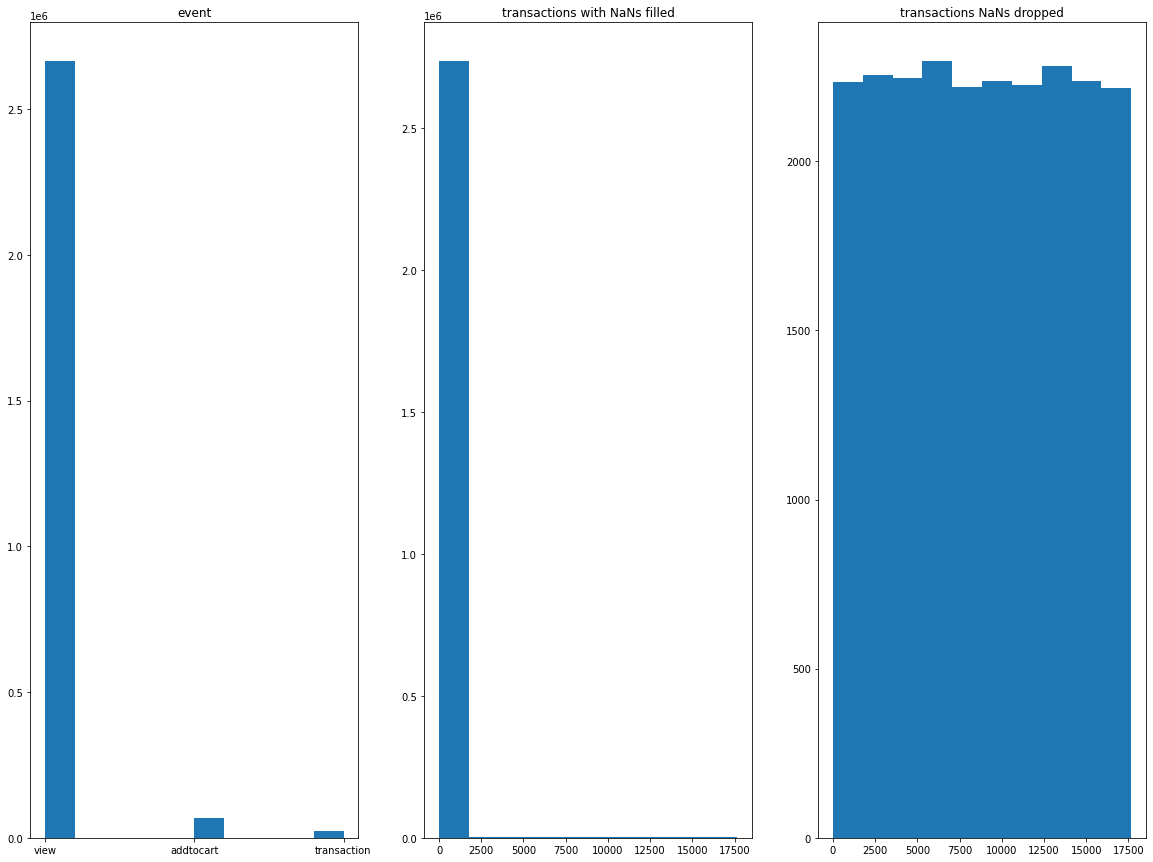

In [10]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 15))

ax[0].hist(eventsDf["event"])
ax[0].set_title("event")
ax[1].hist(eventsDf["transactionid"].fillna(0))
ax[1].set_title("transactions with NaNs filled")
ax[2].hist(eventsDf["transactionid"].dropna())
ax[2].set_title("transactions NaNs dropped")

plt.draw()


This further concludes the assumption that most of the users don't have any transactions. We will perform the steps above also for the other two datasets. Starting with the `propertiesDf`.

In [11]:
propertiesDf.sample(10)

,timestamp,itemid,property,value
13917186,1431831600000,78316,283,250259 1176791 1119519 806622 363182
7099795,1436670000000,265566,790,n47880.000
11479790,1435460400000,214881,813,673782
1999569,1431226800000,77040,112,679677
17820393,1433041200000,195110,764,1285872
17061199,1432436400000,339154,19,n36.000 908104
15950433,1437274800000,214926,categoryid,1147
17086759,1432436400000,50030,994,150169 1079844 1069567
4958272,1433646000000,186564,689,150169 610517
12346747,1439694000000,266970,0,769062


As we can already see value has a lot of mixed values. The analysis on this column will therefore be difficult to perform. But a question may be how the `property` and `value` column behave to each other when neither the entry categoryid or available is present. On tp tje datatypes.

In [15]:
propertiesDf.dtypes

timestamp     int64
itemid        int64
property     object
value        object
dtype: object

In [13]:
propertiesDf.describe(include="all")

,timestamp,itemid,property,value
count,2.027590e+07,2.027590e+07,20275902,20275902
unique,NaN,NaN,1104,1966868
top,NaN,NaN,888,769062
freq,NaN,NaN,3000398,1537247
mean,1.435157e+12,2.333904e+05,NaN,NaN
std,3.327798e+09,1.348452e+05,NaN,NaN
min,1.431227e+12,0.000000e+00,NaN,NaN
25%,1.432436e+12,1.165160e+05,NaN,NaN
50%,1.433646e+12,2.334830e+05,NaN,NaN
75%,1.437880e+12,3.503040e+05,NaN,NaN


### Plotting the data by groups<a class="anchor" id="plt_grps"></a>
For this we will part the data into two groups. Users who bought an item and those who don't. Therefore we will first filter out the userIds which made a transaction.

In [30]:
buyingUsers = pd.DataFrame(eventsDf[eventsDf.event == "transaction"]["visitorid"].copy().drop_duplicates(keep="first").reset_index(drop=True))
buyingUsers.shape[0]

11719

The number of visitors who made a transaction and bought something is 11719. This number alone doesn't say alot. But compared to the number of all visitors we will get a better outlook of how many users made a transaction.

In [31]:
buyingUsers.shape[0]/eventsDf["visitorid"].unique().shape[0]

0.00832563690873698

Only 8.33% of the visitors made an actual transaction. That is a small number we have to lay our focus on to identify potential buyers. But now we will further process the `eventsDf` for analysis.

In [37]:
buyingUsers["bought"] = 1

procEventsDf = pd.merge(eventsDf, buyingUsers, on="visitorid", how="left")
procEventsDf["bought"].fillna(0, inplace=True)
procEventsDf = pd.get_dummies(procEventsDf, columns=["event"], prefix="items")
procEventsDf = procEventsDf[
    ["visitorid", "bought", "items_view", "items_addtocart", "items_transaction"]
    ].groupby(["visitorid", "bought"], as_index=False).sum()
procEventsDf.sample(10)



,visitorid,bought,items_view,items_addtocart,items_transaction
1034188,1034188,0.0,1.0,0.0,0.0
1118188,1118188,0.0,1.0,0.0,0.0
1250783,1250783,0.0,1.0,0.0,0.0
413673,413673,0.0,1.0,0.0,0.0
828150,828150,0.0,1.0,0.0,0.0
748167,748167,0.0,2.0,0.0,0.0
1393911,1393911,0.0,1.0,0.0,0.0
824687,824687,0.0,1.0,0.0,0.0
157549,157549,0.0,1.0,0.0,0.0
213695,213695,0.0,3.0,0.0,0.0


## Data Preparation

1. Cast the column `timestamp` from UNIX timestampe to datetime object in every dataset.
2. Cast `transactionid` in `eventsDf` to integer.

## Footnotes
[1]<a class="anchor" id="kaggle_dataset"></a> Retailrocket (2017) Retailrocket recommender system dataset, Version 4. Retrieved 2020-04-19 from https://www.kaggle.com/retailrocket/ecommerce-dataset

[2]<a class="anchor" id="crisp-dm_diagramm"></a> Wolf Riepel (2012). CRISP-DM: Ein Standard-Prozess-Modell für Data Mining. Retrieved 2020-05-10 from https://statistik-dresden.de/archives/1128